# Leaf Classification using Machine Learning
Group 3: Chen Ruo, Lechong Zhou, Ruoyu Xiang

# Datasets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cv2

%matplotlib inline

# Read the .csv files as pandas dataframe
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

print(train_raw.iloc[:,2:194])

#print type(train_raw), type(test_raw)
print ('There are', train_raw.shape[0], \
       'samples for building the machine learning model and', test_raw.shape[0], \
       'samples for evaluation.')

      margin1   margin2   margin3   margin4   margin5   margin6   margin7  \
0    0.007812  0.023438  0.023438  0.003906  0.011719  0.009766  0.027344   
1    0.005859  0.000000  0.031250  0.015625  0.025391  0.001953  0.019531   
2    0.005859  0.009766  0.019531  0.007812  0.003906  0.005859  0.068359   
3    0.000000  0.003906  0.023438  0.005859  0.021484  0.019531  0.023438   
4    0.005859  0.003906  0.048828  0.009766  0.013672  0.015625  0.005859   
5    0.070312  0.093750  0.033203  0.001953  0.000000  0.152340  0.007812   
6    0.021484  0.031250  0.017578  0.009766  0.001953  0.042969  0.039062   
7    0.000000  0.000000  0.037109  0.050781  0.003906  0.000000  0.003906   
8    0.005859  0.001953  0.033203  0.015625  0.001953  0.000000  0.023438   
9    0.000000  0.000000  0.009766  0.037109  0.072266  0.000000  0.000000   
10   0.019531  0.031250  0.001953  0.005859  0.003906  0.013672  0.033203   
11   0.001953  0.001953  0.023438  0.025391  0.076172  0.000000  0.029297   

In [14]:
train_raw.head(5)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


# Data Preprocessing

In [18]:
# Preprocess the data to fit for the classifier
le = LabelEncoder().fit(train_raw.species) # Instantiate a LabelEncoder and fit to the given label data
labels = le.transform(train_raw.species)  # encode species strings and return labels with value between 0 and n_classes-1
classes = list(le.classes_)  # Save the species
test_ids = test_raw.id  # Save the image ids in test dataset

train = train_raw.drop(['id', 'species'], axis=1)
test = test_raw.drop(['id'], axis=1)

In [21]:
# Double check the data
print ("The shapes of train and labels are: ", train.shape, labels.shape)
print ("There are {} species in total.".format(len(classes)))
print ("The shapes of test and test_ids are: ", test.shape, test_ids.shape)

The shapes of train and labels are:  (990, 192) (990,)
There are 99 species in total.
The shapes of test and test_ids are:  (594, 192) (594,)


In [22]:
# construct the iterator
ss_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
ss_split.get_n_splits(train, labels)

for train_index, test_index in ss_split.split(train, labels):   
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [23]:
# Double check the data
print (y_train.shape, y_test.shape)

(792,) (198,)


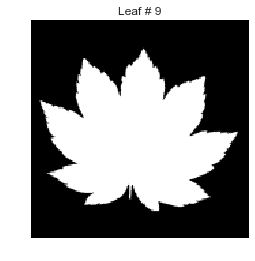

In [30]:
def leaf_image(image_id,target_length=160):
    """
    `image_id` should be the index of the image in the images/ folder
        
    Return the image of a given id(1~1584) with the target size (target_length x target_length)
    
    """
    
    image_name = str(image_id) + '.jpg'
    leaf_img = plt.imread('images/'+image_name)  # Reading in the image 
    leaf_img_width = leaf_img.shape[1]
    leaf_img_height = leaf_img.shape[0]
    #target_length = 160
    img_target = np.zeros((target_length, target_length), np.uint8)
    if leaf_img_width >= leaf_img_height:
        scale_img_width = target_length
        scale_img_height = int( (float(scale_img_width)/leaf_img_width)*leaf_img_height )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_height)/2)
        img_target[copy_location:copy_location+scale_img_height,:] = img_scaled
    else:
        # leaf_img_width < leaf_img_height:
        scale_img_height = target_length
        scale_img_width = int( (float(scale_img_height)/leaf_img_height)*leaf_img_width )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_width)/2)
        img_target[:, copy_location:copy_location+scale_img_width] = img_scaled 
    
    return img_target


# Test the leaf_image function
leaf_id = 9
leaf_img = leaf_image(leaf_id, target_length=160); 

plt.imshow(leaf_img, cmap='gray'); plt.title('Leaf # '+str(leaf_id)); plt.axis('off'); plt.show()

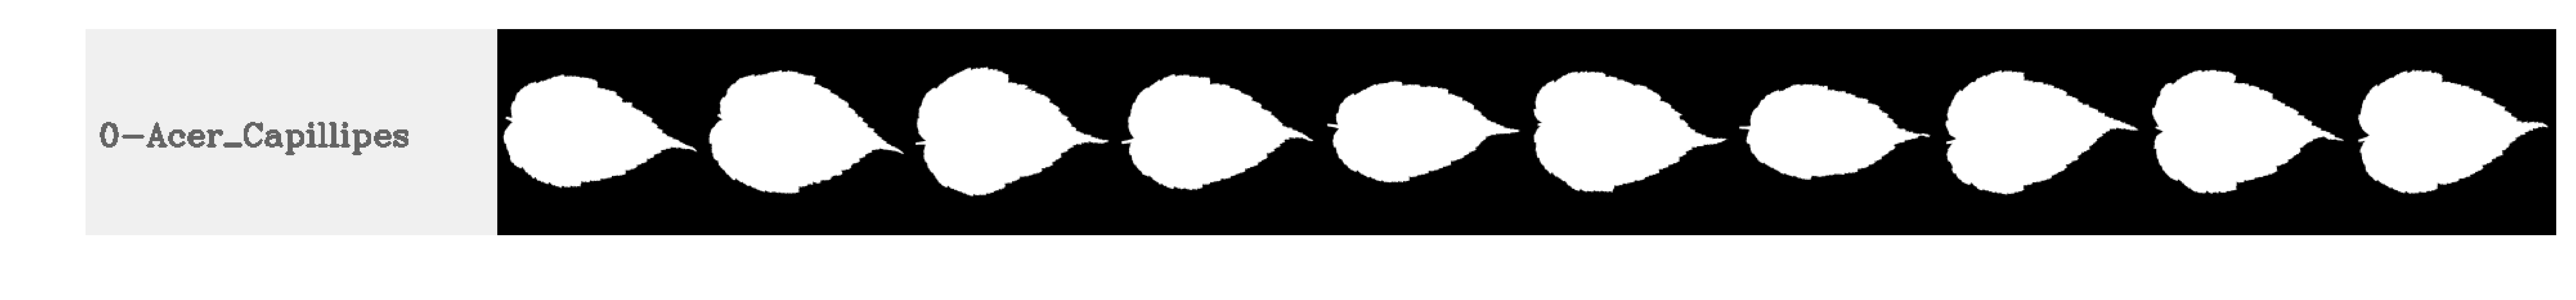

0-Acer_Capillipes


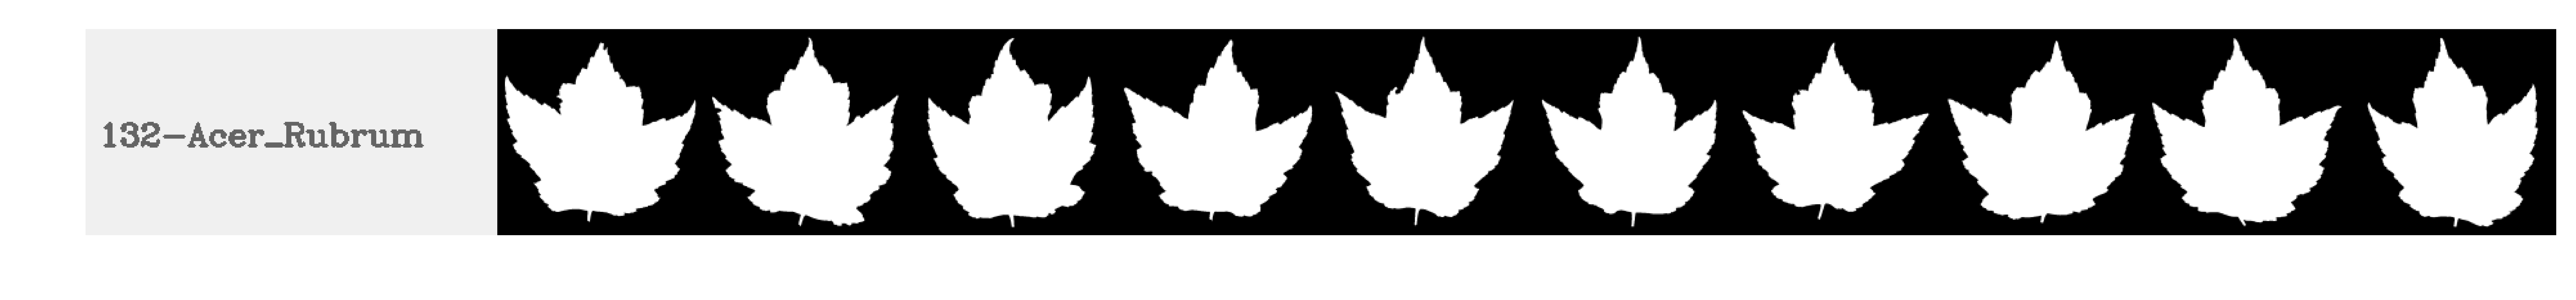

In [34]:
def species_image(species):
    """
    `species` should be the index or species name
        
    Returns an image of a certain labeled species
    """
    
    leaf_image_length = 160
    #img_target = np.zeros([leaf_image_length, 0], np.uint8)  # Initialization
    img_target = 240*np.ones([leaf_image_length, leaf_image_length*2], np.uint8)  # Initialization
    label_info = ''
    if type(species)==int and species >= 0 and species < 99:
    #if species >= 0 and species < 99:
        images_index = np.where(labels==species)[0]
        label_info = str(species) + '-' + train_raw.species[images_index[0]]
    elif type(species)==str and species in classes:
        images_index = np.where(train_raw.species==species)[0]
        label_info = str(images_index[0]) + '-' + species
    else:
        print('Error: Please input a valid index or species name')
        return
    for image_index in images_index:
        image_id = train_raw.id[image_index]
        leaf_img = leaf_image(image_id)
        img_target = np.append(img_target, leaf_img, axis=1)
    
    # Add information onto the first block
    cv2.putText(img_target, label_info, (10,90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (100,170,0), 2)
            
    return img_target, label_info
        
    
    
# Test the function
species_img, label_info = species_image(0)  # Show this species of given index(0~98)
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()
print(label_info)
#cv2.imwrite('species/'+label_info+'.jpg', species_img)  # Save the species image


species_img, label_info = species_image('Acer_Rubrum')  # show the species of give name
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()

# Solutions

PCA, Logistic, SVM, NB

In [4]:
import pandas as pd
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.iloc[:,2:194])

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_data.iloc[:,2:194],train_data.iloc[:,1],random_state=0)

      margin1   margin2   margin3   margin4   margin5   margin6   margin7  \
0    0.007812  0.023438  0.023438  0.003906  0.011719  0.009766  0.027344   
1    0.005859  0.000000  0.031250  0.015625  0.025391  0.001953  0.019531   
2    0.005859  0.009766  0.019531  0.007812  0.003906  0.005859  0.068359   
3    0.000000  0.003906  0.023438  0.005859  0.021484  0.019531  0.023438   
4    0.005859  0.003906  0.048828  0.009766  0.013672  0.015625  0.005859   
5    0.070312  0.093750  0.033203  0.001953  0.000000  0.152340  0.007812   
6    0.021484  0.031250  0.017578  0.009766  0.001953  0.042969  0.039062   
7    0.000000  0.000000  0.037109  0.050781  0.003906  0.000000  0.003906   
8    0.005859  0.001953  0.033203  0.015625  0.001953  0.000000  0.023438   
9    0.000000  0.000000  0.009766  0.037109  0.072266  0.000000  0.000000   
10   0.019531  0.031250  0.001953  0.005859  0.003906  0.013672  0.033203   
11   0.001953  0.001953  0.023438  0.025391  0.076172  0.000000  0.029297   

The range of the data is small, no scaler.

PCA + Logistic Regression + Ridge regularization, try PCA WITH C = 1 - 99

In [6]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Regularization Range C:
C = [0.1, 1, 10, 100, 1000]

accuracy = 0
best_nc = 0
best_c = 0


for nc in range(1,100):
    for c in C:
        pca = PCA(n_components=nc).fit(X_train)
        X_train_pca = pca.transform(X_train) 
        X_test_pca = pca.transform(X_test)
        FittedLogRegModel= LogisticRegression(C=c).fit(X_train_pca,Y_train) 
        score = FittedLogRegModel.score(X_test_pca, Y_test)
        if score > accuracy :
            accuracy = score
            best_nc = nc
            best_c = c
        #print("When number of components =",nc, ", Regularization strength =", c,
         #", the accuracy is",score)
            
print(accuracy)
print(best_nc)
print(best_c)

0.91935483871
40
1000


Logistic Regression + Lasso regularization

In [7]:
best_acc = 0
best_strength = 0

for c in C:
    FittedLogRegModel= LogisticRegression(C=c, penalty="l1").fit(X_train,Y_train) 
    score = FittedLogRegModel.score(X_test, Y_test)
    if score > best_acc :
            best_acc = score
            best_strength = c
            
print(best_acc)
print(best_strength)

0.899193548387
1000


PCA + NB

In [8]:
accuracy = 0
best_nc = 0
best_c = 0

for nc in range(1,100):
    pca = PCA(n_components=nc).fit(X_train)
    X_train_pca = pca.transform(X_train) 
    X_test_pca = pca.transform(X_test)
    gnb=GaussianNB().fit(X_train_pca,Y_train) 
    score = gnb.score(X_test_pca, Y_test)
    if score > accuracy :
        accuracy = score
        best_nc = nc
        #print("When number of components =",nc, ", Regularization strength =", c,
         #", the accuracy is",score)
            
print(accuracy)
print(best_nc)

#ONLY NB, WITHOUT PCA
gnb=GaussianNB().fit(X_train,Y_train) 
score = gnb.score(X_test, Y_test)
print(score)

0.850806451613
46
0.451612903226


SVM + PCA

In [9]:
from sklearn.svm import SVC
c = [0.001, 0.1, 1, 10, 1000]
g = [0.001, 0.1, 1, 10, 1000]
best_model = [0,0]
best_acc = 0
best_nc = 0

for C in c:
    for G in g:
        for nc in range(30,50):
            pca = PCA(n_components=nc).fit(X_train)
            X_train_pca = pca.transform(X_train) 
            X_test_pca = pca.transform(X_test)
            svmModel=SVC(kernel='rbf', gamma=G, C=C).fit(X_train_pca,Y_train)
            score = svmModel.score(X_test_pca, Y_test)
            if score > best_acc:
                best_acc = score
                best_model[0] = C
                best_model[1] = G
                best_nc = nc
            
print('The best SVM classifier model is with C =',best_model[0], 'Gamma =', best_model[1])
print('The accuracy is',best_acc,', the number of component =', best_nc)

The best SVM classifier model is with C = 1000 Gamma = 0.1
The accuracy is 0.911290322581 , the number of component = 47


Only SVM

In [10]:
best_model = [0,0]
best_acc = 0

for C in c:
    for G in g:
        svmModel=SVC(kernel='rbf', gamma=G, C=C).fit(X_train_pca,Y_train)
        score = svmModel.score(X_test_pca, Y_test)
        if score > best_acc:
            best_acc = score
            best_model[0] = C
            best_model[1] = G
            
print('The best SVM classifier model is with C =',best_model[0], 'Gamma =', best_model[1])
print('The accuracy is',best_acc)

The best SVM classifier model is with C = 1000 Gamma = 0.1
The accuracy is 0.907258064516


In [11]:
best_model = [0,0]
best_acc = 0

for C in c:
    for G in g:
        svmModel=SVC(kernel='sigmoid', gamma=G, C=C).fit(X_train_pca,Y_train)
        score = svmModel.score(X_test_pca, Y_test)
        if score > best_acc:
            best_acc = score
            best_model[0] = C
            best_model[1] = G
            
print('The best SVM classifier model is with C =',best_model[0], 'Gamma =', best_model[1])
print('The accuracy is',best_acc)

The best SVM classifier model is with C = 1000 Gamma = 0.1
The accuracy is 0.907258064516


In [12]:
best_model = [0,0]
best_acc = 0

for C in c:
    for G in g:
        svmModel=SVC(kernel='linear', gamma=G, C=C).fit(X_train_pca,Y_train)
        score = svmModel.score(X_test_pca, Y_test)
        if score > best_acc:
            best_acc = score
            best_model[0] = C
            best_model[1] = G
            
print('The best SVM classifier model is with C =',best_model[0], 'Gamma =', best_model[1])
print('The accuracy is',best_acc)

The best SVM classifier model is with C = 1000 Gamma = 0.001
The accuracy is 0.907258064516


k-NN

In [13]:
# Importing some useful/necessary packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from numpy import *

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Read the .csv files as pandas dataframe
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

In [14]:
# Preprocess the data to fit for the classifier
le = LabelEncoder().fit(train_raw.species) # Instantiate a LabelEncoder and fit to the given label data
labels = le.transform(train_raw.species)  # encode species strings and return labels with value between 0 and n_classes-1
classes = list(le.classes_)  # Save the species
test_ids = test_raw.id  # Save the image ids in test dataset

train = train_raw.drop(['id', 'species'], axis=1)
test = test_raw.drop(['id'], axis=1)

In [15]:
ss_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
ss_split.get_n_splits(train, labels)

for train_index, test_index in ss_split.split(train, labels):   
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [16]:
print ("The shapes of train and labels are: ", train.shape, labels.shape)
print ("There are {} species in total.".format(len(classes)) )
print ("The shapes of test and test_ids are: ", test.shape, test_ids.shape)

The shapes of train and labels are:  (990, 192) (990,)
There are 99 species in total.
The shapes of test and test_ids are:  (594, 192) (594,)


In [17]:
clf = KNeighborsClassifier(2)  # Instantiate a classifier
clf.fit(X_train, y_train) # Fit this classifier to the data
print ('ML Model: ', clf.__class__.__name__)

# Cross-validation
scores = cross_val_score(KNeighborsClassifier(3), train.values, labels, cv=ss_split)
#print 'Mean Cross-validation scores: {}'.format(np.mean(scores))

train_predictions = clf.predict(X_test)
acc = clf.score(X_test,y_test)
print ('Accuracy: {:.4%}'.format(acc))

train_predictions = clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print ('Log Loss: {:.6}'.format(ll))

ML Model:  KNeighborsClassifier
Accuracy: 87.3737%
Log Loss: 2.18078


when k is  1 , Accuracy: 91.9192%
when k is  2 , Accuracy: 87.3737%
when k is  3 , Accuracy: 87.8788%
when k is  4 , Accuracy: 83.8384%
when k is  5 , Accuracy: 84.3434%
when k is  6 , Accuracy: 81.3131%
when k is  7 , Accuracy: 79.7980%
when k is  8 , Accuracy: 79.7980%
when k is  9 , Accuracy: 79.7980%
when k is  10 , Accuracy: 79.7980%
when k is  15 , Accuracy: 75.7576%


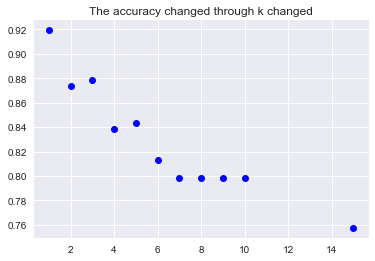

In [18]:
K =[1,2,3,4,5,6,7,8,9,10,15]
for i in K:
    clf = KNeighborsClassifier(i)  # Instantiate a classifier
    clf.fit(X_train, y_train) # Fit this classifier to the data
        
    # Cross-validation
    scores = cross_val_score(KNeighborsClassifier(i), train.values, labels, cv=ss_split)
    #print 'Mean Cross-validation scores: {}'.format(np.mean(scores))

    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test,y_test)
    print ('when k is ',i,', Accuracy: {:.4%}' .format(acc))
    plt.plot(i,acc,'bo')
    
plt.grid(True)
plt.legend(bbox_to_anchor=(.68, 1), loc=1, borderaxespad=0.)
plt.title("The accuracy changed through k changed" %acc )
plt.show()

Clustering

In [20]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

K-Means, Score is %s 0.516327926222


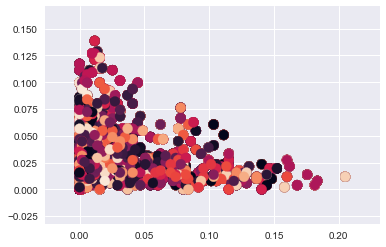

In [21]:
for i in range(0,30):
    kgood=0;
    clusters_kmeans = KMeans(n_clusters=99).fit_predict(X_train)
    plt.scatter(X_train[:, 1], X_train[:, 2], c=clusters_kmeans, s=100)
    score_Kmeans=adjusted_rand_score(clusters_kmeans,y_train)
    if(score_Kmeans>kgood):
        kgood=score_Kmeans

print("K-Means, Score is %s",kgood  )

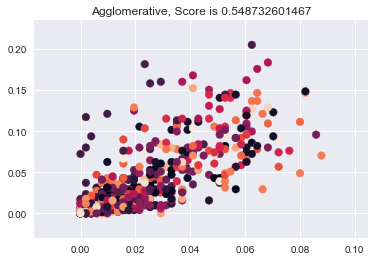

In [22]:
clusters_Agglomerative = AgglomerativeClustering(n_clusters=99, linkage='ward').fit_predict(X_train)

score_Agglomerative=adjusted_rand_score(clusters_Agglomerative,y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters_Agglomerative, s=60)
plt.title("Agglomerative, Score is %s" %score_Agglomerative )
plt.show()

PCA Analysis

In [23]:
scaler=StandardScaler().fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)
print("the shape of data before PCA",shape(X_train_scale))

pca=PCA(n_components=27).fit(X_train_scale)
X_train_pca=pca.transform(X_train_scale)
X_test_pca=pca.transform(X_test_scale)
print("the shape of data after PCA",shape(X_train_pca))
print(pca.explained_variance_ratio_ )


the shape of data before PCA (792, 192)
the shape of data after PCA (792, 27)
[ 0.24173376  0.10432419  0.0629824   0.05640631  0.042427    0.03542774
  0.0310459   0.02779341  0.02482345  0.02071155  0.01769606  0.01716251
  0.01571479  0.01462501  0.01288361  0.01257176  0.01127525  0.01047923
  0.00970039  0.00931117  0.00861722  0.00810806  0.00766576  0.00757145
  0.0066732   0.00617393  0.00610499]


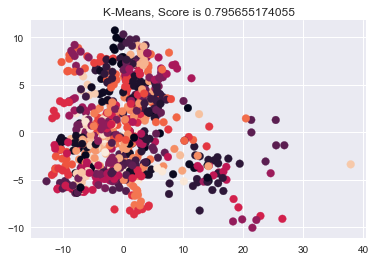

In [24]:
clusters_kmeans = KMeans(n_clusters=99).fit_predict(X_train_pca)

score_Kmeans=adjusted_rand_score(clusters_kmeans,y_train)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters_kmeans, s=60)
plt.title("K-Means, Score is %s" %score_Kmeans )
plt.show()

the shape of data before PCA (792, 192)
PCA Component number: 20 K-Means, Score is 0.775842624003
PCA Component number: 21 K-Means, Score is 0.767214465606
PCA Component number: 22 K-Means, Score is 0.752467212603
PCA Component number: 23 K-Means, Score is 0.790287762307
PCA Component number: 24 K-Means, Score is 0.732987228024
PCA Component number: 25 K-Means, Score is 0.804418447774
PCA Component number: 26 K-Means, Score is 0.786505783898
PCA Component number: 27 K-Means, Score is 0.784651313335
PCA Component number: 28 K-Means, Score is 0.773935503685
PCA Component number: 29 K-Means, Score is 0.792531621695
PCA Component number: 30 K-Means, Score is 0.773516133161
PCA Component number: 31 K-Means, Score is 0.767853340558
PCA Component number: 32 K-Means, Score is 0.803027988679
PCA Component number: 33 K-Means, Score is 0.79200870605
PCA Component number: 34 K-Means, Score is 0.816819154568
PCA Component number: 35 K-Means, Score is 0.804718611466
PCA Component number: 36 K-Means,

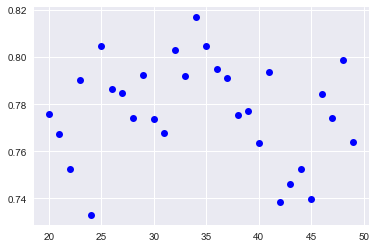

In [25]:
scaler=StandardScaler().fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)
print("the shape of data before PCA",shape(X_train_scale))
for num in range(20,50):
    pca=PCA(n_components=num).fit(X_train_scale)
    X_train_pca=pca.transform(X_train_scale)
    X_test_pca=pca.transform(X_test_scale)
    #print(pca.explained_variance_ratio_ )
    for i in range(0,30):
        kgood=0;
        clusters_kmeans = KMeans(n_clusters=99).fit_predict(X_train_pca)
        score_Kmeans=adjusted_rand_score(clusters_kmeans,y_train)
        if(score_Kmeans>kgood):
            kgood=score_Kmeans

    plt.plot(num,kgood,'bo')    
    print("PCA Component number:",num, "K-Means, Score is %s" %score_Kmeans )
    
plt.show()

As we can see in the chart, when PCA component between 20 and 30, the kmeans generaly performances good. When Component equal to 43, the model also performens good. However, because the kmeans model depends on it's initial spread which means the high accuracy just because it has good initial.

PCA number: 10 Agglomerative, Score is 0.737193709124
PCA number: 11 Agglomerative, Score is 0.737363245784
PCA number: 12 Agglomerative, Score is 0.749139533283
PCA number: 13 Agglomerative, Score is 0.763023100149
PCA number: 14 Agglomerative, Score is 0.791744559275
PCA number: 15 Agglomerative, Score is 0.802068841254
PCA number: 16 Agglomerative, Score is 0.797779012632
PCA number: 17 Agglomerative, Score is 0.80892210846
PCA number: 18 Agglomerative, Score is 0.801120472585
PCA number: 19 Agglomerative, Score is 0.811636018174
PCA number: 20 Agglomerative, Score is 0.81681519409
PCA number: 21 Agglomerative, Score is 0.830581176348
PCA number: 22 Agglomerative, Score is 0.795149131432
PCA number: 23 Agglomerative, Score is 0.828199520983
PCA number: 24 Agglomerative, Score is 0.824119289491
PCA number: 25 Agglomerative, Score is 0.815836827276
PCA number: 26 Agglomerative, Score is 0.818400561144
PCA number: 27 Agglomerative, Score is 0.819933945215
PCA number: 28 Agglomerative, 

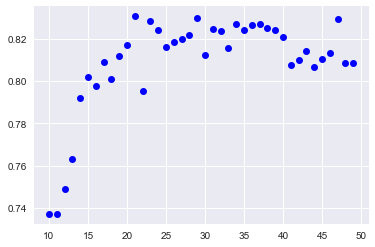

In [26]:
for num in range(10,50):
    pca=PCA(n_components=num).fit(X_train_scale)
    X_train_pca=pca.transform(X_train_scale)
    X_test_pca=pca.transform(X_test_scale)
    clusters_Agglomerative = AgglomerativeClustering(n_clusters=99, linkage='ward').fit_predict(X_train_pca)
    score_Agglomerative=adjusted_rand_score(clusters_Agglomerative,y_train)
    #plt.scatter(X_train[:, 33], X_train[:, 41], c=clusters_Agglomerative, s=60)
    print("PCA number:",num,"Agglomerative, Score is %s" %score_Agglomerative )
    plt.plot(num,score_Agglomerative,'bo')
plt.show()

As we can see in the chart, the best PCA component number is 27, which the accuracy is 83.9%

In [27]:
pca=PCA(n_components=27).fit(X_train_scale)
X_train_pca=pca.transform(X_train_scale)
X_test_pca=pca.transform(X_test_scale)
clusters_Agglomerative = AgglomerativeClustering(n_clusters=99, linkage='ward').fit_predict(X_train_pca)
score_Agglomerative=adjusted_rand_score(clusters_Agglomerative,y_train)
#plt.scatter(X_train[:, 33], X_train[:, 41], c=clusters_Agglomerative, s=60)
print("PCA number:27, Agglomerative, Score is %s" %score_Agglomerative )


PCA number:27, Agglomerative, Score is 0.827915362837


PCA, LDA, QDA

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
#print(train_data.iloc[:,2:194])
X_train, X_test, Y_train, Y_test = train_test_split(train_data.iloc[:,2:194],train_data.iloc[:,1],random_state=0)

PCA + LDA (n_components)

In [21]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score

accuracy = 0
best_nc1 = 0
best_nc2 = 0

for nc1 in range(1,100):
    for nc2 in range(1,100):
        pca = PCA(copy=True, iterated_power='auto', n_components=nc1, random_state=None,
          svd_solver='auto', tol=0.0, whiten=False).fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        LDAmodelFitted = LinearDiscriminantAnalysis(n_components=nc2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001).fit(X_train_pca, Y_train)
        #print(LDAmodelFitted.predict(X_test.iloc[0:1,:]))
        score = LDAmodelFitted.score(X_test_pca, Y_test)
        if score > accuracy:
            accuracy = score
            best_nc1 = nc1
            best_nc2 = nc2

pca = PCA(copy=True, iterated_power='auto', n_components=best_nc1, random_state=None,
          svd_solver='auto', tol=0.0, whiten=False).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
LDAmodelFitted = LinearDiscriminantAnalysis(n_components=best_nc2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001).fit(X_train_pca, Y_train)            

print('Accuracy', accuracy)
print('Best nc1', nc1)
print('Best nc2', nc2)

predictedOutput = LDAmodelFitted.predict(X_test_pca) 
confusion = confusion_matrix(Y_test,predictedOutput)
precision =  precision_score(Y_test,predictedOutput,average='weighted')
recall = recall_score(Y_test,predictedOutput,average='weighted')
print(confusion)
print('precision_score', precision)
print('recall_score',recall)

Accuracy 0.95564516129
Best nc1 99
Best nc2 99
[[3 0 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 5 0]
 [0 0 0 ..., 0 0 3]]
precision_score 0.961693548387
recall_score 0.943548387097


/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


PCA + LDA (default)

In [22]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score

accuracy = 0
best_nc = 0

for nc in range(1,100):
    pca = PCA(copy=True, iterated_power='auto', n_components=nc, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    LDAmodelFitted = LinearDiscriminantAnalysis().fit(X_train_pca, Y_train)
    #print(LDAmodelFitted.predict(X_test.iloc[0:1,:]))
    score = LDAmodelFitted.score(X_test_pca, Y_test)
    if score > accuracy:
        accuracy = score
        best_nc = nc

pca = PCA(copy=True, iterated_power='auto', n_components=best_nc, random_state=None,
          svd_solver='auto', tol=0.0, whiten=False).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
LDAmodelFitted = LinearDiscriminantAnalysis().fit(X_train_pca, Y_train)            

print('Accuracy', accuracy)
print('Best nc1', nc)

predictedOutput = LDAmodelFitted.predict(X_test_pca) 
confusion = confusion_matrix(Y_test,predictedOutput)
precision =  precision_score(Y_test,predictedOutput,average='weighted')
recall = recall_score(Y_test,predictedOutput,average='weighted')
print(confusion)
print('precision_score', precision)
print('recall_score',recall)

Accuracy 0.947580645161
Best nc1 99
[[3 0 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 5 0]
 [0 0 0 ..., 0 0 3]]
precision_score 0.961693548387
recall_score 0.947580645161


/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


LDA only

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score

accuracy = 0
best_nc = 0

for nc in range(1,100):
    LDAmodelFitted = LinearDiscriminantAnalysis(n_components=nc, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001).fit(X_train, Y_train)
    #print(LDAmodelFitted.predict(X_test.iloc[0:1,:]))
    score = LDAmodelFitted.score(X_test, Y_test)
    if score > accuracy:
        accuracy = score
        best_nc = nc
        
LDAmodelFitted = LinearDiscriminantAnalysis(n_components=nc, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001).fit(X_train, Y_train)            

print('Accuracy', accuracy)
print('Best nc', nc)

predictedOutput = LDAmodelFitted.predict(X_test) 
confusion = confusion_matrix(Y_test,predictedOutput)
precision =  precision_score(Y_test,predictedOutput,average='weighted')
recall = recall_score(Y_test,predictedOutput,average='weighted')
print(confusion)
print('precision_score', precision)
print('recall_score',recall)

/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy 0.983870967742
Best nc 99
[[3 0 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 5 0]
 [0 0 0 ..., 0 0 4]]
precision_score 0.985887096774
recall_score 0.983870967742


/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


QDA

In [24]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score

accuracy = 0
best_nc = 0

for nc in range(1,100):
    pca = PCA(copy=True, iterated_power='auto', n_components=nc, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    QDAmodelFitted = QuadraticDiscriminantAnalysis().fit(X_train_pca, Y_train)
    #print(LDAmodelFitted.predict(X_test.iloc[0:1,:]))
    score = QDAmodelFitted.score(X_test_pca, Y_test)
    if score > accuracy:
        accuracy = score
        best_nc = nc

pca = PCA(copy=True, iterated_power='auto', n_components=best_nc, random_state=None,
          svd_solver='auto', tol=0.0, whiten=False).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
QDAmodelFitted = QuadraticDiscriminantAnalysis().fit(X_train_pca, Y_train)            

print('Accuracy', accuracy)
print('Best nc1', nc)

predictedOutput = QDAmodelFitted.predict(X_test_pca) 
confusion = confusion_matrix(Y_test,predictedOutput)
precision =  precision_score(Y_test,predictedOutput,average='weighted')
recall = recall_score(Y_test,predictedOutput,average='weighted')
print(confusion)
print('precision_score', precision)
print('recall_score',recall)

/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy 0.379032258065
Best nc1 99
[[3 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]]
precision_score 0.4223406298
recall_score 0.379032258065


/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/florar.xiang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
